# Определение пневмонии на рентгеновских снимках

Это задание посвящено детектированию пневмонии на рентгеновских снимках груди.

Ваша цель создать точный алгоритм детектирования визуальных свидетельств пневмонии.

In [1]:
import os
import sys
import random
import math
import numbers
from collections.abc import Iterable
import numpy as np
import cv2
import matplotlib.pyplot as plt
import json
from collections import defaultdict
from tqdm import tqdm
import pandas as pd
import glob
from sklearn.model_selection import KFold
import pydicom
from tqdm import tqdm_notebook
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import StratifiedKFold
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor, FasterRCNN
from torchvision.models.detection import fasterrcnn_resnet50_fpn
import torch
import torchvision
from torchvision.models.detection import FasterRCNN
from sklearn.model_selection import ShuffleSplit
from torchvision.models.detection.rpn import AnchorGenerator
from torchvision.models.detection.rpn import RPNHead
from torchvision import transforms
from PIL import Image
import torchvision.transforms.functional as F

from NNUtils import iou, map_iou, evaluate, collate_fn, cleanup, wh_box_to_coord, parse_submissions, soft_nms
from NNUtils import load_test_image, get_test_predictions, get_sub_list, write_submission
from DatasetUtils import RSNADataset, visualize_pair

# переопределим методы pytorch для корректной работы с box

from MyTransforms import AbstractTransform, Compose, ToTensor, ToPILImage, RandomRotation, RandomCrop, Resize

random.seed(42)

In [2]:
# wget для скачивания torchvision utils, которые не входят в pypi
!wget https://raw.githubusercontent.com/pytorch/vision/master/references/detection/utils.py -O utils.py
import utils

--2019-11-25 02:29:09--  https://raw.githubusercontent.com/pytorch/vision/master/references/detection/utils.py
Распознаётся raw.githubusercontent.com (raw.githubusercontent.com)… 151.101.244.133
Подключение к raw.githubusercontent.com (raw.githubusercontent.com)|151.101.244.133|:443... соединение установлено.
HTTP-запрос отправлен. Ожидание ответа… 200 OK
Длина: 9796 (9,6K) [text/plain]
Сохранение в: «utils.py»

utils.py            100%[===================>]   9,57K  --.-KB/s    за 0s      

2019-11-25 02:29:10 (22,2 MB/s) - «utils.py» сохранён [9796/9796]



In [3]:
def get_dicom_fps(data_dir):
    dicom_fps = glob.glob(os.path.join(data_dir, "*.dcm"))
    return list(set(dicom_fps))


def parse_dataset(data_dir, anns):
    image_fps = get_dicom_fps(data_dir)
    image_annotations = {fp: [] for fp in image_fps}
    for index, row in anns.iterrows():
        fp = os.path.join(data_dir, row["patientId"] + ".dcm")
        image_annotations.get(fp, []).append(row)
    return image_fps, image_annotations

## Загрузим датасет

Данные скачивались с https://www.kaggle.com/c/rsna-pneumonia-detection-challenge/data . Для дальнейшей работы укажите в переменной data_path локальный путь к данным.

In [4]:
data_path = "data/rsna-pneumonia-detection-challenge/"
train_img_path = os.path.join(data_path, "stage_2_train_images")
annotations = pd.read_csv(os.path.join(data_path, "stage_2_train_labels.csv"))

image_fps, image_annotations = parse_dataset(train_img_path, anns=annotations)

## Посмотрим на мета-информацию в .dcm файлах

In [5]:
ds = pydicom.read_file(image_fps[0])
ds

(0008, 0005) Specific Character Set              CS: 'ISO_IR 100'
(0008, 0016) SOP Class UID                       UI: Secondary Capture Image Storage
(0008, 0018) SOP Instance UID                    UI: 1.2.276.0.7230010.3.1.4.8323329.7998.1517874334.933758
(0008, 0020) Study Date                          DA: '19010101'
(0008, 0030) Study Time                          TM: '000000.00'
(0008, 0050) Accession Number                    SH: ''
(0008, 0060) Modality                            CS: 'CR'
(0008, 0064) Conversion Type                     CS: 'WSD'
(0008, 0090) Referring Physician's Name          PN: ''
(0008, 103e) Series Description                  LO: 'view: AP'
(0010, 0010) Patient's Name                      PN: '6f6eea6d-aeca-48ad-a730-ba52981111cd'
(0010, 0020) Patient ID                          LO: '6f6eea6d-aeca-48ad-a730-ba52981111cd'
(0010, 0030) Patient's Birth Date                DA: ''
(0010, 0040) Patient's Sex                       CS: 'F'
(0010, 1010) Patient's

В этой табличке для каждого пациента содержится информация о расположении поражений легких. Часть пациентов здорова, на таких изображениях стоит метка 0 и нет контура объекта.

In [6]:
img_size = 1024

## Класс для работы с изображениями в pytorch

Основная функция __getitem__ -- возвращает тензор изображения и метки к нему. Поля в словаре target подчиняются требованием torchvision (репозиторий с предобученными моделями, https://pytorch.org/tutorials/intermediate/torchvision_tutorial.html ).

In [7]:
transforms_list = Compose([ToPILImage(),RandomRotation(7),RandomCrop((900,900)),Resize(1024),ToTensor()])

dataset = RSNADataset(image_fps[:2000], image_annotations, img_size, img_size, train=True, 
                      transforms_list = transforms_list, add_mask = False)


## Посмотрим на случайное изображение больного пациента

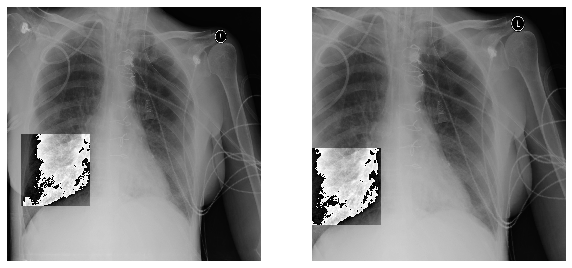

In [8]:
visualize_pair(dataset)

## Функция для получения модели

In [9]:
def get_model(num_classes):
    # Предобученная на COCO fasterrcnn
    model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)
    
    in_features = model.roi_heads.box_predictor.cls_score.in_features
    # Заменим "голову" классификатора на новую, которую обучим на нашем датасете
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

    anchor_generator = AnchorGenerator(sizes=((32, 64, 128, 256),),
                                       aspect_ratios=((0.25, 0.5, 1.0, 1.5, 2.0),))
    roi_pooler = torchvision.ops.MultiScaleRoIAlign(featmap_names=[0],
                                                    output_size=32,
                                                    sampling_ratio=2)
    model.box_roi_pool = roi_pooler
    model.rpn_anchor_generator = anchor_generator

    return model

In [10]:
def get_model_instance_segmentation(num_classes):
    model = torchvision.models.detection.maskrcnn_resnet50_fpn(pretrained=True)
    
    in_features = model.roi_heads.box_predictor.cls_score.in_features
    
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

    in_features_mask = model.roi_heads.mask_predictor.conv5_mask.in_channels
    
    hidden_layer = 256
    
    model.roi_heads.mask_predictor = MaskRCNNPredictor(in_features_mask, hidden_layer, num_classes)

    return model

In [11]:
def train_one_epoch(model, optimizer, data_loader, device, epoch, print_freq):
    model.train()
    metric_logger = utils.MetricLogger(delimiter="  ")
    metric_logger.add_meter('lr', utils.SmoothedValue(window_size=1, fmt='{value:.6f}'))
    header = 'Epoch: [{}]'.format(epoch)

    for images, targets in metric_logger.log_every(data_loader, print_freq, header):
        images = list(image.to(device) for image in images)
        targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

        loss_dict = model(images, targets)

        losses = sum(loss for loss in loss_dict.values())

        # reduce losses over all GPUs for logging purposes
        loss_dict_reduced = utils.reduce_dict(loss_dict)
        losses_reduced = sum(loss for loss in loss_dict_reduced.values())

        loss_value = losses_reduced.item()

        if not math.isfinite(loss_value):
            print("Loss is {}, stopping training".format(loss_value))
            print(loss_dict_reduced)
            sys.exit(1)

        optimizer.zero_grad()
        
        losses.backward()
        optimizer.step()

        metric_logger.update(loss=losses_reduced, **loss_dict_reduced)
        metric_logger.update(lr=optimizer.param_groups[0]["lr"])


In [12]:
def make_validation(images_files, cv, params, image_annotations):
    img_size = params.get("img_size", 1024)
    num_classes = params.get("num_classes", 2)
    num_epochs = params.get("num_epochs", 5)
    device = params.get("device", "cpu")
    transforms_list = params.get("transf_list", None)
    masked_model = params.get("masked_model", False)
    save_name = params.get("save_name", None)

    scores = np.zeros(len(cv))
    for fold_num, (train_idx, val_idx) in enumerate(cv):
        train_images = list(images_files[train_idx])
        # Будем обучаться только на изображениях с пневмонией
        train_images = [filename for filename in train_images if image_annotations[filename][0].Target > 0]
        val_images = list(images_files[val_idx])

        dataset = RSNADataset(train_images, image_annotations, img_size, img_size, train=True,
                              transforms_list=transforms_list, add_mask=masked_model)

        dataset_val = RSNADataset(val_images, image_annotations, img_size, img_size, train=False)

        data_loader = torch.utils.data.DataLoader(
            dataset, batch_size=6, shuffle=True, num_workers=6, collate_fn=collate_fn)

        data_loader_val = torch.utils.data.DataLoader(
            dataset_val, batch_size=6, shuffle=False, num_workers=6,
            collate_fn=collate_fn)

        if masked_model:
            model = get_model_instance_segmentation(num_classes)
        else:
            model = get_model(num_classes)

        model.to(device)

        params = [p for p in model.parameters() if p.requires_grad]
        optimizer = torch.optim.SGD(params, lr=0.005,
                                    momentum=0.9, weight_decay=0.00005)

        lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer,
                                                       step_size=2,
                                                       gamma=0.1)

        for epoch in range(num_epochs):
            print("epoch {}".format(epoch))
            train_one_epoch(model, optimizer, data_loader, device, epoch, print_freq=10)

            lr_scheduler.step()

            fold_score = evaluate(model, data_loader_val, device=device)
            print("score: {}".format(fold_score))
            scores[fold_num] = fold_score

        if save_name:
            torch.save(model.state_dict(), save_name)
        else:
            torch.save(model.state_dict(), "fold_num_{}_model".format(fold_num))
        del model

    print("average val score: {}".format(np.mean(scores)))

## Функции для получения итоговых предсказаний

In [13]:
def train(random_state, masked_model, model_name, image_annotations):
    n_splits = 1
    cv = list(ShuffleSplit(n_splits=n_splits, random_state=random_state, test_size=0.2).split(np.zeros((len(image_fps), 1)),
                                                                       np.zeros(len(image_fps))))

    transforms_list = Compose([ToPILImage(),RandomRotation(7),RandomCrop((900,900)),Resize(1024),ToTensor()])


    device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
    num_classes = 2
    print("your device: {}".format(device))

    params = {"img_size": img_size, "num_classes": num_classes, "num_epochs": 5, "device": device,
             "transforms_list": transforms_list, "masked_model":masked_model, "save_name": model_name}

    images_files = np.array(image_fps)

    make_validation(images_files=images_files, cv=cv, params=params, image_annotations=image_annotations)

In [14]:
def predict(model_name, masked):
    num_classes = 2
    device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

    if masked:
        model = get_model_instance_segmentation(num_classes=num_classes)
    else:
        model = get_model(num_classes=num_classes)
    model.load_state_dict(torch.load(""))
    model.to(device)

    test_images = get_dicom_fps(os.path.join(data_path, "test_data"))

    imgs_info = get_test_predictions(model, test_images, device, img_size)
    
    del model
    
    return imgs_info

    # min_conf -- минимальный порог уверенности для того, чтобы считать объект пневмонией
    sub_list = get_sub_list(imgs_info, img_size, min_conf=0)

    write_submission(sub_list, mask_aug_all.csv)

In [ ]:
#first model - faster-rcnn+aug
random.seed(42)
train(15, False, 'Aug_faster_rcnn1', image_annotations)

imgs_info = predict('Aug_faster_rcnn1', False)

#all candidates - for model combination
sub_list_all = get_sub_list(imgs_info, img_size, min_conf=0)
write_submission(sub_list_all, 'faster1_aug_all.csv')

#for submission
sub_list_all = get_sub_list(imgs_info, img_size, min_conf=0.7)
write_submission(sub_list_all, 'submission_aug1.csv')


In [ ]:
#second model - masked-rcnn+aug
random.seed(42)
train(15, True, 'Aug_masked_rcnn1', image_annotations)

imgs_info = predict('Aug_masked_rcnn1', True)

#all candidates - for model combination
sub_list_all = get_sub_list(imgs_info, img_size, min_conf=0)
write_submission(sub_list_all, 'masked1_aug_all.csv')

#for submission
sub_list_all = get_sub_list(imgs_info, img_size, min_conf=0.7)
write_submission(sub_list_all, 'submission_mask2.csv')


In [ ]:
# combination
new_imgs_info = soft_nms(['masked1_aug_all.csv', 'faster1_aug_all.csv'])
sub_list = get_sub_list(new_imgs_info, img_size, min_conf=0.75)
write_submission(sub_list, filename='submission_av2.csv')